In [ ]:
"""
Requirements
pip install scipy==1.9.3 scanpy igraph harmonypy 
"""
import os

import scanpy as sc
import pandas as pd
import harmonypy as hm
import celltypist

# Define Filenames
H5_FILENAME = 'GSE178341_crc10x_full_c295v4_submit.h5'
H5AD_FILENAME = H5_FILENAME.replace('.h5', '.h5ad')


In [ ]:
if os.path.exists(H5_FILENAME) and not os.path.exists(H5AD_FILENAME):
    # Convert h5 to h5AD (Roughly 10 minutes)
    adata = sc.read_10x_h5(H5_FILENAME)
    adata.write_h5ad(H5AD_FILENAME)

In [ ]:
# Read h5AD File 
adata = sc.read_h5ad("GSE178341_crc10x_full_c295v4_submit.h5ad")

In [ ]:
# Create Gene Expression Table to Upload into CytoTRACE (Roughly 13 minutes)
# Convert Sparse to Dense Matrix
dense_matrix = adata.X.toarray()

# Create DataFrame
df = pd.DataFrame(
    dense_matrix.T,  # Transpose Matrix to get into following format: [genes x cells]
    index=adata.var_names,  
    columns=adata.obs_names
)

# Export to CSV
df.to_csv("cytotrace_input_normalized.csv")

In [ ]:
# Identify mitochondrial genes (assuming human dataset with 'MT-' prefix)
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# Compute QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

# View QC metrics
print(adata.obs[["total_counts", "n_genes_by_counts", "pct_counts_mt"]].head())

In [ ]:
# Define QC thresholds
min_genes = 200  # Cells must have at least 200 genes
max_genes = 5000  # Remove cells with very high gene counts
max_mt = 5  # Remove cells with >5% mitochondrial RNA

# Apply filtering
adata = adata[adata.obs.n_genes_by_counts > min_genes, :]
adata = adata[adata.obs.n_genes_by_counts < max_genes, :]
adata = adata[adata.obs.pct_counts_mt < max_mt, :]

print(f"Remaining cells after filtering: {adata.n_obs}")

In [ ]:
# Filter Out Low-Quality Genes
sc.pp.filter_genes(adata, min_cells=3)  # Keep genes present in at least 3 cells

In [ ]:
# Normalize & Log-Transform Data for downstream analysis
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
# Identify Highly Variable Genes
# Select genes that show high variability across cells
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Keep only highly variable genes
adata = adata[:, adata.var.highly_variable]

print(f"Number of highly variable genes: {adata.shape[1]}")

In [ ]:
# Save the Processed Data
adata.write("GSE178341_QC.h5ad")

In [3]:
adata = sc.read_h5ad("GSE178341_QC.h5ad")

In [19]:
# Read metadata
metadata = pd.read_csv("GSE178341_crc10x_full_c295v4_submit_metatables.csv")
print(metadata.head())

                                   cellID SPECIMEN_TYPE SOURCE_HOSPITAL  \
0  C103_T_1_1_0_c1_v2_id-AAACCTGCATGCTAGT             T             MGH   
1  C103_T_1_1_0_c1_v2_id-AAACCTGGTAGCCTAT             T             MGH   
2  C103_T_1_1_0_c1_v2_id-AAACCTGGTTGTCGCG             T             MGH   
3  C103_T_1_1_0_c1_v2_id-AAACCTGTCATGTGGT             T             MGH   
4  C103_T_1_1_0_c1_v2_id-AAACCTGTCCTTGGTC             T             MGH   

  TISSUE_PROCESSING_TEAM PROCESSING_TYPE SINGLECELL_TYPE PatientTypeID  \
0                Hacohen        unsorted          SC3Pv2        C103_T   
1                Hacohen        unsorted          SC3Pv2        C103_T   
2                Hacohen        unsorted          SC3Pv2        C103_T   
3                Hacohen        unsorted          SC3Pv2        C103_T   
4                Hacohen        unsorted          SC3Pv2        C103_T   

  HistologicTypeSimple    MMR_IHC MMRStatus  ... NodeStatus_detailed  \
0       Adenocarcinoma  preserve

In [20]:
if 'MMRStatus' not in adata.obs.columns:
    # Import the MMR Statuses (merge in the metadata by matching the cell IDs)
    adata.obs = adata.obs.reset_index()
    adata.obs = adata.obs.merge(metadata[['cellID', 'MMRStatus']], left_on='index', right_on='cellID', how='left')
    adata.obs = adata.obs.set_index('index')

    # Clean up duplicate column after merge
    adata.obs.drop(columns=['cellID'], inplace=True)

In [21]:
# Check counts of MMRd vs. MMRp
print(adata.obs["MMRStatus"].value_counts())  

MMRStatus
MMRp    37076
MMRd    29365
Name: count, dtype: int64


In [ ]:
"""
Formatting for Batch Correction
FORMAT obs_names = C[PatientID]_[Region]_[X]_[Y]_[Z]_c[Cluster]_v[Version]_[Barcode]
T, N, TA, TB → Sample Type / Region
    T → Tumor sample
    N → Normal (adjacent) tissue
    TA, TB → Multiple tumor regions (possibly from different sections of the same tumor or replicates from the same patient)
"""
obs_names = adata.obs_names.str.split('_')
adata.obs["batch"] = obs_names.str[0]     # Patient IDs
adata.obs["region"] = obs_names.str[1]    # Sample Regions
print(adata.obs["batch"].value_counts())  # Number of cells per patient sample

batch
C129    6895
C126    6013
C132    5579
C124    5026
C130    4283
        ... 
C168      90
C160      86
C172      83
C173      75
C161      33
Name: count, Length: 62, dtype: int64


In [24]:
# Separate dataset into MMRp, MMRd, and isolate tumor cells
adata_MMRp = adata[adata.obs['MMRStatus'] == 'MMRp'].copy()
adata_MMRd = adata[adata.obs['MMRStatus'] == 'MMRd'].copy()
adata_tumor = adata[adata.obs['region'] == 'T'].copy()

In [30]:
# Perform PCA and clustering 
# For MMRp
sc.tl.pca(adata_MMRp, svd_solver='arpack')
sc.pp.neighbors(adata_MMRp, n_neighbors=10, n_pcs=40)

# For MMRd
sc.tl.pca(adata_MMRd, svd_solver='arpack')
sc.pp.neighbors(adata_MMRd, n_neighbors=10, n_pcs=40)

# For Tumor Cells
sc.tl.pca(adata_tumor, svd_solver='arpack')
sc.pp.neighbors(adata_tumor, n_neighbors=10, n_pcs=40)

In [ ]:
# Run Harmony for batch correction (8.5 minutes)
adata_MMRp.obsm["X_pca_harmony"] = hm.run_harmony(adata_MMRp.obsm["X_pca"], adata_MMRp.obs, 'batch').Z_corr.T # transpose result to fit expected shape
adata_MMRd.obsm["X_pca_harmony"] = hm.run_harmony(adata_MMRd.obsm["X_pca"], adata_MMRd.obs, 'batch').Z_corr.T
adata_tumor.obsm["X_pca_harmony"] = hm.run_harmony(adata_tumor.obsm["X_pca"], adata_tumor.obs, 'batch').Z_corr.T

2025-03-11 22:31:02,458 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-03-11 22:31:20,249 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-03-11 22:31:21,027 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2025-03-11 22:31:46,940 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2025-03-11 22:32:08,568 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2025-03-11 22:32:30,191 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2025-03-11 22:32:39,611 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2025-03-11 22:32:48,898 - harmonypy - INFO - Converged after 5 iterations
Converged after 5 iterations
2025-03-11 22:32:48,989 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-03-11 22:33:07,408 - harmonypy - INFO - sklearn.KMeans initializatio

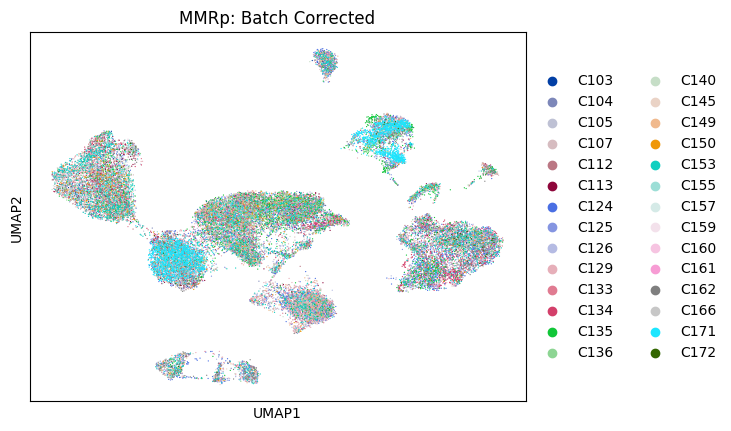

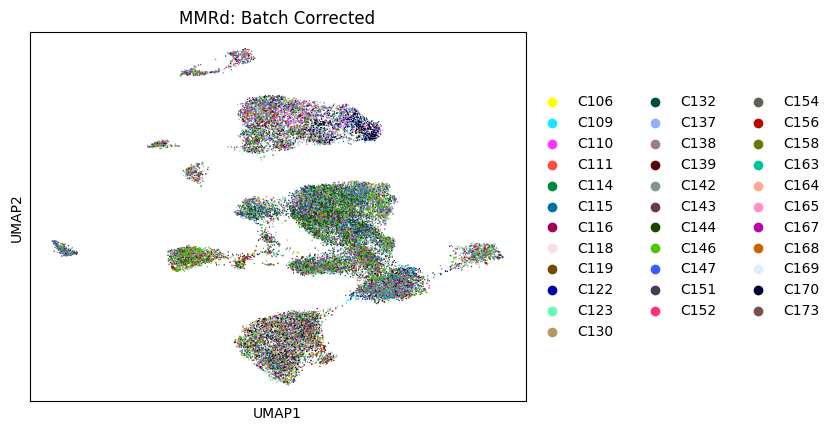

... storing 'MMRStatus' as categorical
... storing 'batch' as categorical
... storing 'region' as categorical


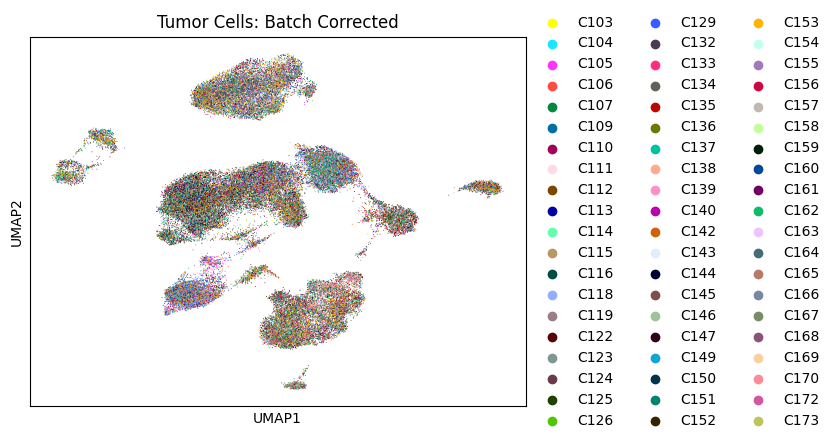

In [ ]:
# Update neighbors & recompute UMAP (3.5 minutes)
sc.pp.neighbors(adata_MMRp, use_rep="X_pca_harmony")
sc.tl.umap(adata_MMRp)
sc.pl.umap(adata_MMRp, color="batch", title="MMRp: Batch Corrected")

sc.pp.neighbors(adata_MMRd, use_rep="X_pca_harmony")
sc.tl.umap(adata_MMRd)
sc.pl.umap(adata_MMRd, color="batch", title="MMRd: Batch Corrected")

sc.pp.neighbors(adata_tumor, use_rep="X_pca_harmony")
sc.tl.umap(adata_tumor)
sc.pl.umap(adata_tumor, color="batch", title="Tumor Cells: Batch Corrected")

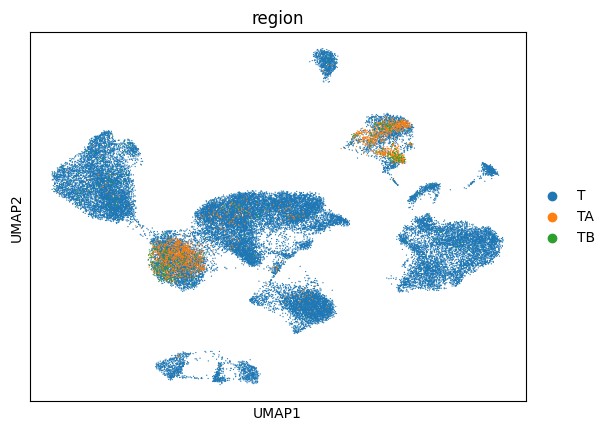

In [39]:
# Verify Teal Cluster is due to Biological Variation not Leftover Batch Effects
sc.pl.umap(adata_MMRp, color=['region'])

In [40]:
# Leiden clustering 
sc.tl.leiden(adata_MMRp, resolution=0.5, flavor="igraph", n_iterations=2, directed=False)
sc.tl.leiden(adata_MMRd, resolution=0.5, flavor="igraph", n_iterations=2, directed=False)
sc.tl.leiden(adata_tumor, resolution=0.5, flavor="igraph", n_iterations=2, directed=False)

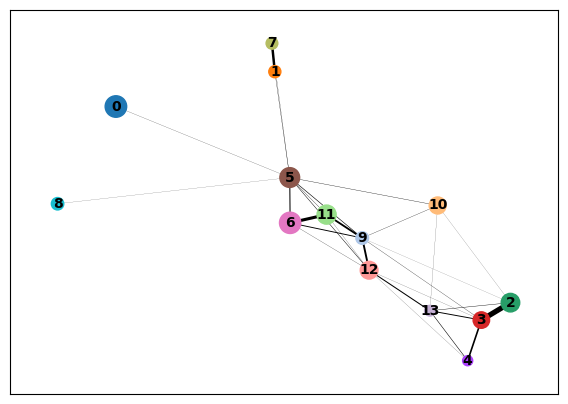

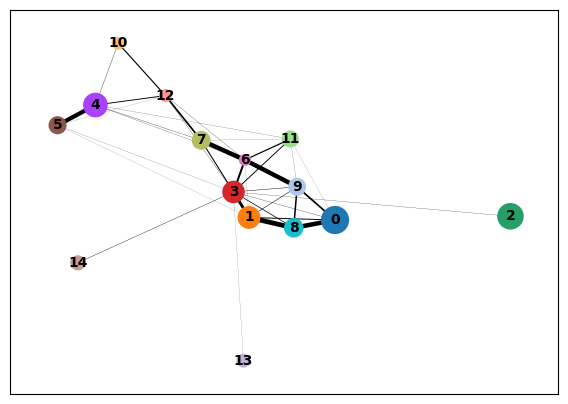

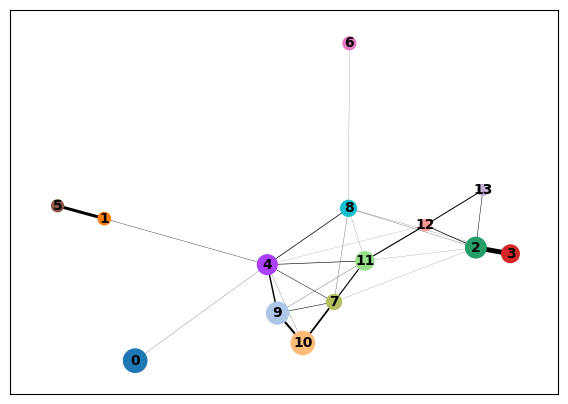

In [33]:
# Run PAGA for RNA Trajectory Analysis
sc.tl.paga(adata_MMRp, groups='leiden')
sc.tl.paga(adata_MMRd, groups='leiden')
sc.tl.paga(adata_tumor, groups='leiden')

# Plot PAGA Graph
sc.pl.paga(adata_MMRp, color=['leiden'])
sc.pl.paga(adata_MMRd, color=['leiden'])
sc.pl.paga(adata_tumor, color=['leiden'])

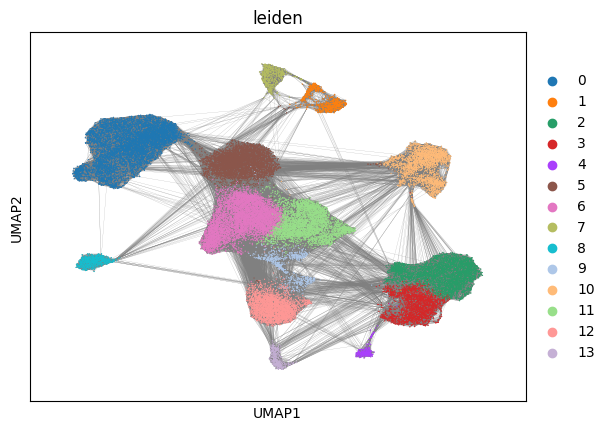

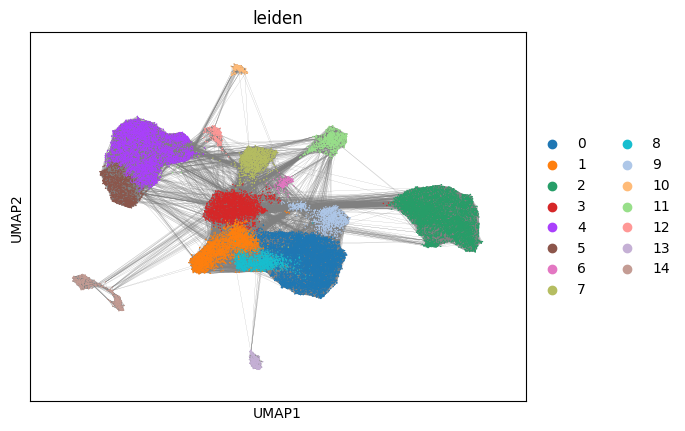

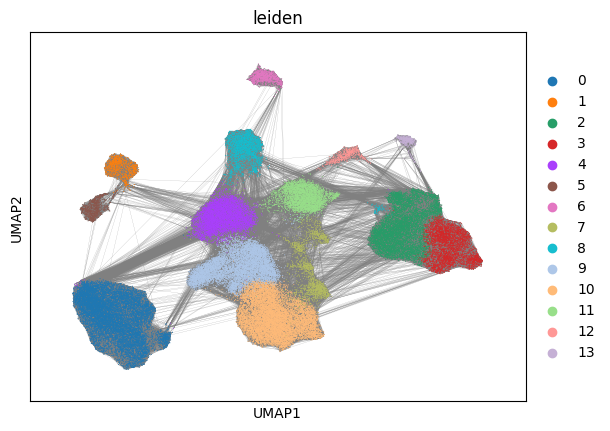

In [34]:
sc.tl.umap(adata_MMRp, init_pos='paga')
sc.tl.umap(adata_MMRd, init_pos='paga')
sc.tl.umap(adata_tumor, init_pos='paga')

sc.pl.umap(adata_MMRp, color=['leiden'], edges=True)
sc.pl.umap(adata_MMRd, color=['leiden'], edges=True)
sc.pl.umap(adata_tumor, color=['leiden'], edges=True)

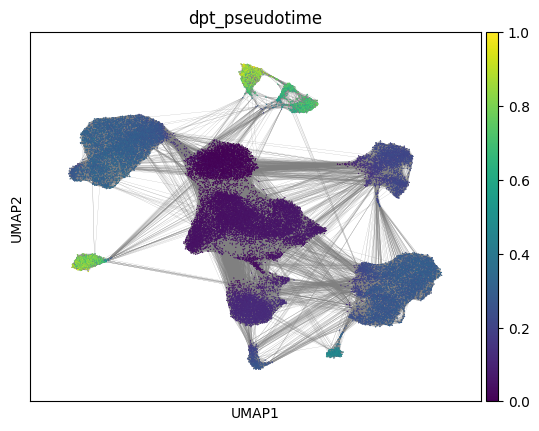

In [ ]:
# Pick root cluster number (TODO NEED HELP TO CHOOSE FROM TA)
root_cluster_MMRp = '5'  
# Find a cell index in that cluster to set as root
root_cell_index_MMRp = adata_MMRp.obs.query('leiden == @root_cluster_MMRp').index[0]
# Assign the root cell
adata_MMRp.uns['iroot'] = adata_MMRp.obs_names.get_loc(root_cell_index_MMRp)
# Run Diffusion Pseudotime
sc.tl.dpt(adata_MMRp)
# Create new UMAP
sc.pl.umap(adata_MMRp, color='dpt_pseudotime', edges=True)

# Pick root cluster number (TODO NEED HELP TO CHOOSE FROM TA)
root_cluster_MMRd = '5'  
# Find a cell index in that cluster to set as root
root_cell_index_MMRd = adata_MMRd.obs.query('leiden == @root_cluster_MMRd').index[0]
# Assign the root cell
adata_MMRd.uns['iroot'] = adata_MMRd.obs_names.get_loc(root_cell_index_MMRd)
# Run Diffusion Pseudotime
sc.tl.dpt(adata_MMRd)
# Create new UMAP
sc.pl.umap(adata_MMRd, color='dpt_pseudotime', edges=True)

In [ ]:
# Find the top-expressed genes in each cluster
sc.tl.rank_genes_groups(adata_MMRp, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata_MMRp, n_genes=10, sharey=False)

sc.tl.rank_genes_groups(adata_MMRd, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata_MMRd, n_genes=10, sharey=False)

sc.tl.rank_genes_groups(adata_tumor, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata_tumor, n_genes=10, sharey=False)

🔬 Input data has 37076 cells and 2237 genes
🔗 Matching reference genes in the model
🧬 1398 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 29365 cells and 2237 genes
🔗 Matching reference genes in the model
🧬 1398 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


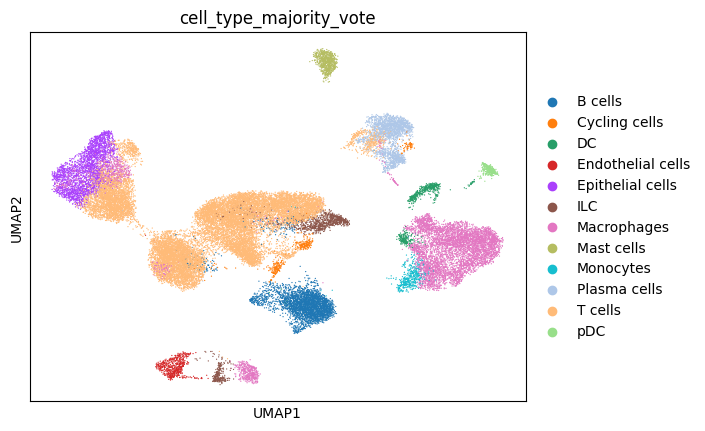

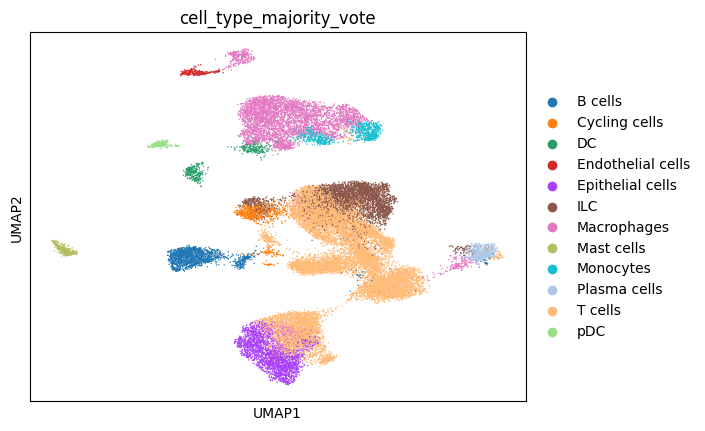

In [44]:
# Label Clusters with CellTypist

# Normalize total counts per cell to 10,000
sc.pp.normalize_total(adata_MMRp, target_sum=1e4)
sc.pp.normalize_total(adata_MMRd, target_sum=1e4)

# Annotate AnnData object
model = celltypist.models.Model.load('Immune_All_High.pkl')
MMRp_predictions = celltypist.annotate(adata_MMRp, model=model, majority_voting=True)
MMRd_predictions = celltypist.annotate(adata_MMRd, model=model, majority_voting=True)

# Add predictions to AnnData obs
adata_MMRp.obs['cell_type'] = MMRp_predictions.predicted_labels['predicted_labels']
adata_MMRp.obs['cell_type_majority_vote'] = MMRp_predictions.predicted_labels['majority_voting']

adata_MMRd.obs['cell_type'] = MMRd_predictions.predicted_labels['predicted_labels']
adata_MMRd.obs['cell_type_majority_vote'] = MMRd_predictions.predicted_labels['majority_voting']

# Plot UMAPs with predicted cell types
sc.tl.umap(adata_MMRp)
sc.pl.umap(adata_MMRp, color='cell_type_majority_vote')

sc.tl.umap(adata_MMRd)
sc.pl.umap(adata_MMRd, color='cell_type_majority_vote')

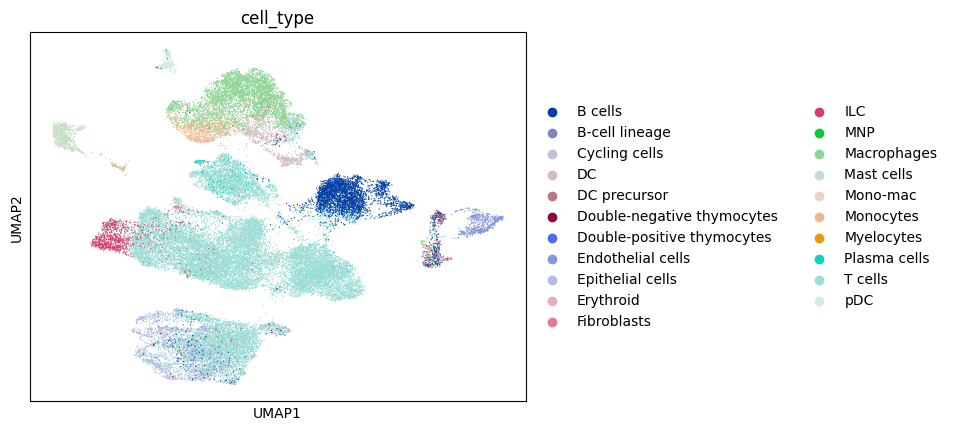

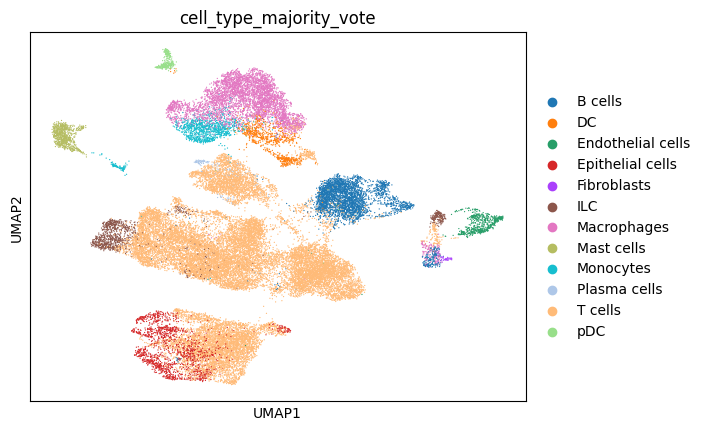

In [ ]:
# Rank genes by cell type (leiden cluster)
sc.tl.rank_genes_groups(adata, groupby="cell_type", method="wilcoxon")

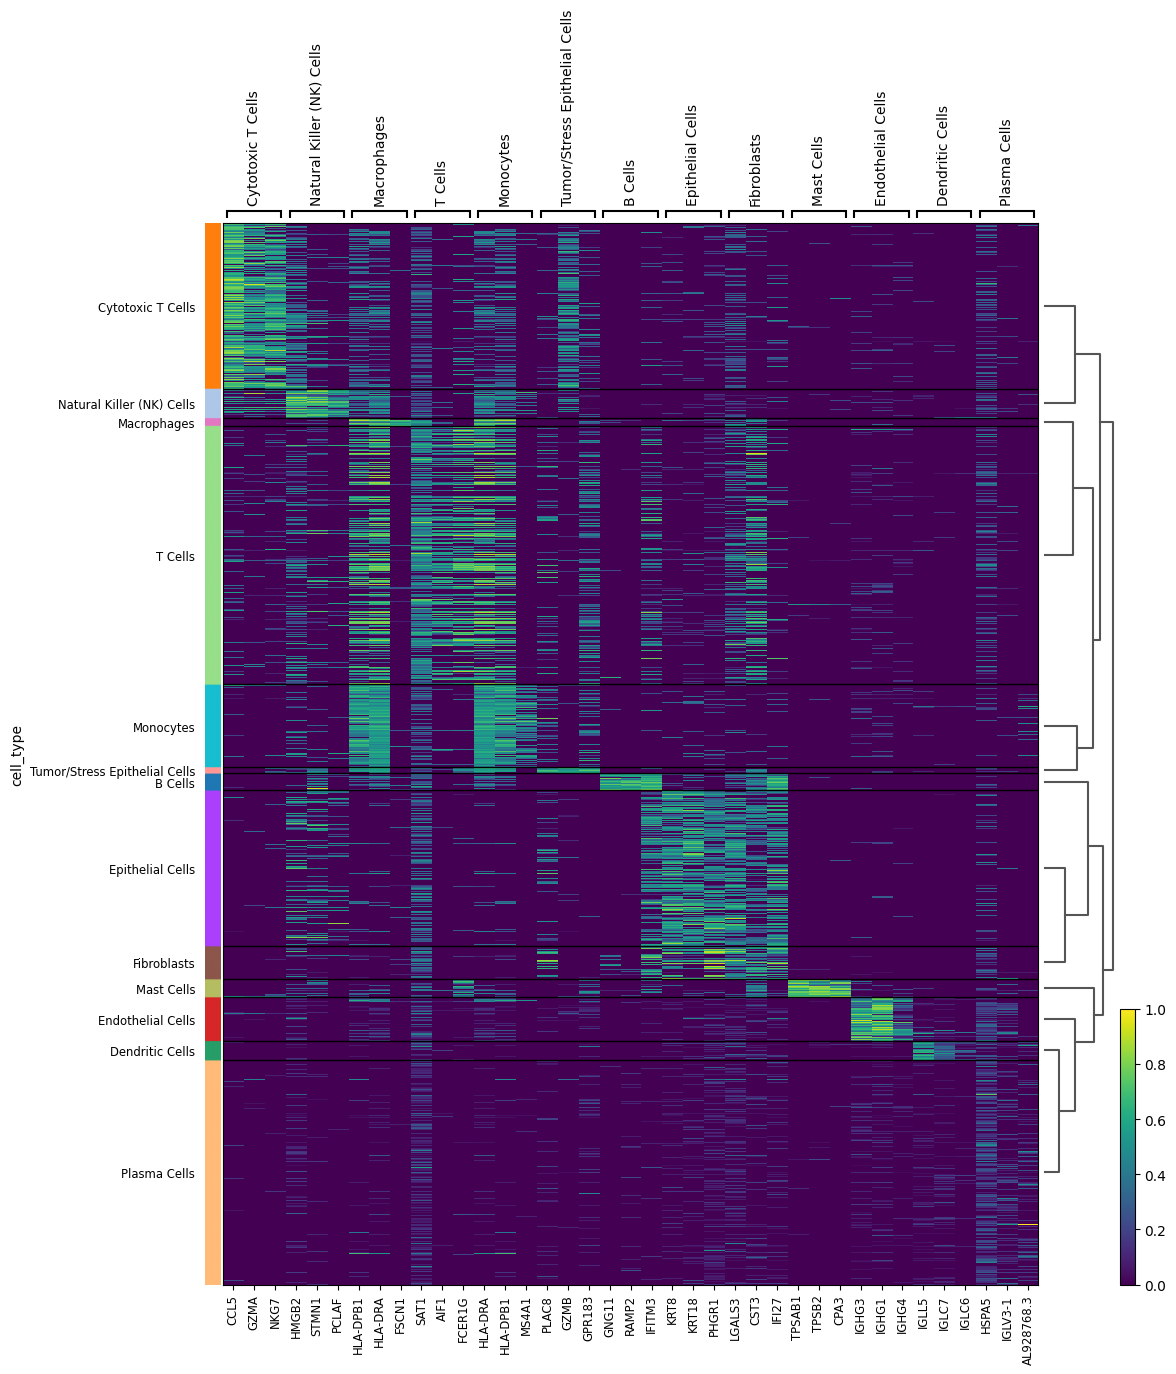

In [ ]:
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=3,
    groupby="cell_type",
    cmap="viridis",
    standard_scale="var",
    figsize=(12, 14),
)